In [1]:
# Imports
#

import numpy             as np
import matplotlib        as mpl
import matplotlib.pyplot as plt
import math

In [2]:
# Set config constants

n_train, n_val, n_test = 3000, 1000, 3000
n_tot = sum([n_train, n_val, n_test])

radius_boundary_1, radius_boundary_2 = 0.6, 1.2

sqrt_2 = np.sqrt(2)

mpl.rcParams['font.size'] = 16

In [3]:
# Ground-truth function for classifying points
#

def classify (p) :
    if type(p) != np.ndarray :
        if p < radius_boundary_1 : return np.array([1, 0, 0])
        if p < radius_boundary_2 : return np.array([0, 1, 0])
        return np.array([0, 0, 1])
    if p.shape == 1 :
        p = np.array([p])
    if len(p.shape) == 2 :
        radii = np.linalg.norm(p, axis=1)
    else :
        raise ValueError(f"cannot get radii for list of points with shape {p.shape} ((n_points, n_dim) expected)")
    return np.array([classify(r) for r in radii])

In [4]:
# Function for plotting classified points
#

def plot_points (points, labels, **kwargs) :
    pnts_A = np.array([p for p, l in zip(points, labels) if l[0] > max(l[1], l[2])])
    pnts_B = np.array([p for p, l in zip(points, labels) if l[1] > max(l[0], l[2])])
    pnts_C = np.array([p for p, l in zip(points, labels) if l[2] > max(l[0], l[1])])
    plt.axis((-1.*sqrt_2, sqrt_2, -1.*sqrt_2, sqrt_2))
    if pnts_A.shape[0] > 0 :
        plt.scatter(pnts_A[:,0], pnts_A[:,1], marker="o", c="g", s=4, alpha=0.4)
    if pnts_B.shape[0] > 0 :
        plt.scatter(pnts_B[:,0], pnts_B[:,1], marker="o", c="r", s=4, alpha=0.4)
    if pnts_C.shape[0] > 0 :
        plt.scatter(pnts_C[:,0], pnts_C[:,1], marker="o", c="b", s=4, alpha=0.4)
    theta = np.linspace(0, 2*math.pi, 100)
    plt.plot(radius_boundary_1*np.cos(theta), radius_boundary_1*np.sin(theta), "--", c="black")
    plt.plot(radius_boundary_2*np.cos(theta), radius_boundary_2*np.sin(theta), "--", c="black")
    if "title" in kwargs : plt.title(kwargs["title"], pad=15)
    plt.xlabel("x", labelpad=20)
    plt.xticks(fontsize="small")
    plt.ylabel("y", rotation="horizontal", labelpad=30)
    plt.yticks(fontsize="small")
    plt.show()

In [5]:
# Function for assigning weights to datapoints based on the class frequency
#

def get_label_weights (labels) :
    n_labels = np.sum(labels, axis=0)
    n_points = np.sum(labels)
    label_weights = np.reciprocal(n_labels/n_points)
    return np.matmul(labels, label_weights)

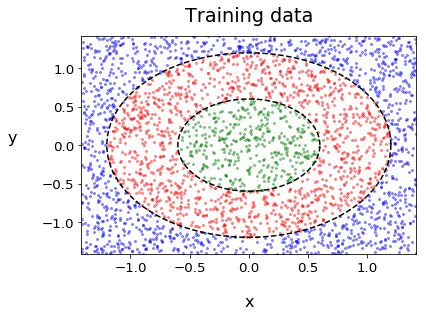

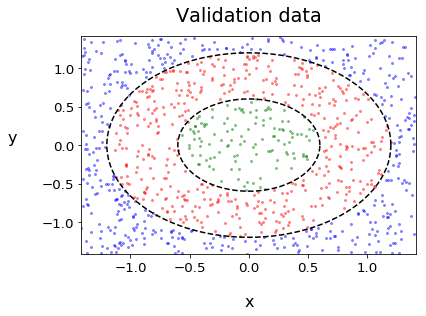

In [6]:
# Generate labelled data in (x, y)-plane over the domain x, y \in [-sqrt(2), sqrt(2)]
#

all_inputs = np.random.uniform(-1.*sqrt_2, sqrt_2, size=(n_tot, 2))
all_labels = classify(all_inputs)

X_train, X_val, X_test = all_inputs[:n_train], all_inputs[n_train:n_train+n_val], all_inputs[n_val:n_val+n_test]
Y_train, Y_val, Y_test = all_labels[:n_train], all_labels[n_train:n_train+n_val], all_labels[n_val:n_val+n_test]
W_train, W_val, W_test = get_label_weights(Y_train), get_label_weights(Y_val), get_label_weights(Y_test)

plot_points(X_train, Y_train, title="Training data")
plot_points(X_val  , Y_val  , title="Validation data")

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

standard_classifier = Sequential(name="Standard Keras classifier")
standard_classifier.add(Dense(64, activation="relu", input_shape=(2,)))
standard_classifier.add(Dropout(0.3))
standard_classifier.add(Dense(64, activation="relu"))
standard_classifier.add(Dropout(0.3))
standard_classifier.add(Dense(64, activation="relu"))
standard_classifier.add(Dense(3 , activation="relu"))
standard_classifier.add(Activation("softmax"))
standard_classifier.compile(optimizer="adam",
                            loss="categorical_crossentropy",
                            metrics=["accuracy"])
#standard_classifier.summary()

In [16]:
from keras.callbacks import EarlyStopping

standard_classifier.fit(X_train,
                        Y_train,
                        sample_weight=W_train,
                        validation_data=(X_val, Y_val, W_val),
                        epochs=10000,
                        callbacks=[EarlyStopping(monitor="val_accuracy", restore_best_weights=True, patience=10)])

Train on 3000 samples, validate on 1000 samples
Epoch 1/10000
3000/3000 [==============================] - 0s 153us/step - loss: 3.0272 - accuracy: 0.4487 - val_loss: 2.4115 - val_accuracy: 0.6020
Epoch 2/10000
3000/3000 [==============================] - 0s 58us/step - loss: 1.7810 - accuracy: 0.7230 - val_loss: 1.0450 - val_accuracy: 0.9120
Epoch 3/10000
3000/3000 [==============================] - 0s 64us/step - loss: 1.0915 - accuracy: 0.8197 - val_loss: 0.7174 - val_accuracy: 0.9120
Epoch 4/10000
3000/3000 [==============================] - 0s 62us/step - loss: 0.9027 - accuracy: 0.8473 - val_loss: 0.6026 - val_accuracy: 0.9290
Epoch 5/10000
3000/3000 [==============================] - 0s 62us/step - loss: 0.8043 - accuracy: 0.8607 - val_loss: 0.5262 - val_accuracy: 0.9400
Epoch 6/10000
3000/3000 [==============================] - 0s 65us/step - loss: 0.7791 - accuracy: 0.8637 - val_loss: 0.4722 - val_accuracy: 0.9550
Epoch 7/10000
3000/3000 [==============================] - 0s 6

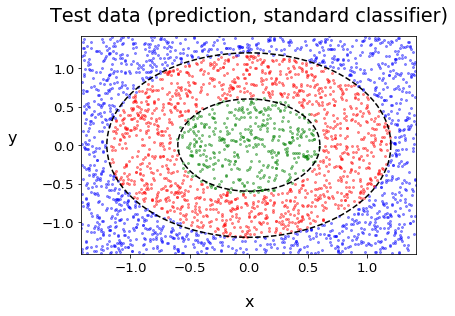

In [17]:
plot_points(X_test, standard_classifier.predict(X_test), title="Test data (prediction, standard classifier)")

In [28]:
from keras        import backend as K
from keras.layers import Layer, Add

class Custom_Dense (Layer) :
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        
        super(Custom_Dense, self).__init__(**kwargs)
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1]+1, self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(Custom_Dense, self).build(input_shape)  # Be sure to call this at the end
    def call(self, x):
        return K.bias_add(K.dot(x, self.kernel[1:]), self.kernel[0])
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [29]:
from keras.models import Model
from keras.layers import Input

model_input = Input(shape=(2,), name="input")
custom_layer_1 = Custom_Dense(64)
custom_layer_2 = Activation("relu")
custom_layer_3 = Dropout(0.3)
custom_layer_4 = Custom_Dense(64)
custom_layer_5 = Activation("relu")
custom_layer_6 = Dropout(0.3)
custom_layer_7 = Custom_Dense(64)
custom_layer_8 = Activation("relu")
custom_layer_9 = Dropout(0.3)
custom_layer_7 = Custom_Dense(3)
custom_layer_8 = Activation("softmax")
model = custom_layer_8(custom_layer_7(custom_layer_6(custom_layer_5(custom_layer_4(custom_layer_3(custom_layer_2(custom_layer_1(model_input))))))))
custom_classifier = Model(inputs=model_input, outputs=model)
custom_classifier.compile(optimizer="adam",
                          loss="categorical_crossentropy",
                          metrics=["accuracy"])

In [30]:
custom_classifier  .fit(X_train,
                        Y_train,
                        sample_weight=W_train,
                        validation_data=(X_val, Y_val, W_val),
                        epochs=10000,
                        callbacks=[EarlyStopping(monitor="val_accuracy", restore_best_weights=True, patience=10)])

Train on 3000 samples, validate on 1000 samples
Epoch 1/10000
3000/3000 [==============================] - 0s 142us/step - loss: 3.2038 - accuracy: 0.4493 - val_loss: 2.8695 - val_accuracy: 0.5270
Epoch 2/10000
3000/3000 [==============================] - 0s 54us/step - loss: 2.2283 - accuracy: 0.6593 - val_loss: 1.5779 - val_accuracy: 0.7670
Epoch 3/10000
3000/3000 [==============================] - 0s 55us/step - loss: 1.4127 - accuracy: 0.7960 - val_loss: 1.0436 - val_accuracy: 0.9420
Epoch 4/10000
3000/3000 [==============================] - 0s 56us/step - loss: 1.1400 - accuracy: 0.8213 - val_loss: 0.8485 - val_accuracy: 0.9080
Epoch 5/10000
3000/3000 [==============================] - 0s 57us/step - loss: 0.9775 - accuracy: 0.8347 - val_loss: 0.7333 - val_accuracy: 0.9370
Epoch 6/10000
3000/3000 [==============================] - 0s 56us/step - loss: 0.9274 - accuracy: 0.8463 - val_loss: 0.6376 - val_accuracy: 0.9270
Epoch 7/10000
3000/3000 [==============================] - 0s 6

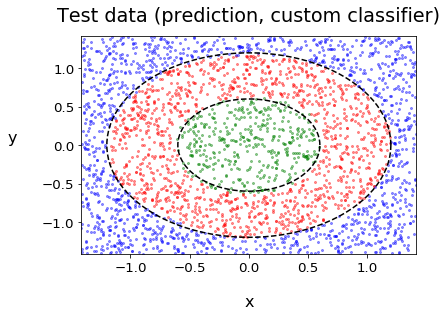

In [31]:
plot_points(X_test, standard_classifier.predict(X_test), title="Test data (prediction, custom classifier)")